## 例9-1. インボート + データ絞り込み

In [1]:
import pandas as pd

# 本文とは異なり、オリジナルデータから20000件のデータを取り出し
model_df = pd.read_json('data/mag_papers/mag_papers_0.txt', lines=True)
model_df = model_df.head(20000)

model_df.shape

(20000, 19)

In [2]:
# 英語でない文献の除去および変数の絞り込み
model_df = model_df[model_df.lang == 'en']\
    .drop_duplicates(subset = 'title', keep = 'first')\
    .drop(['doc_type', 'doi', 'id', 'issue', 'lang', 'n_citation', 'page_end', 'page_start', 'publisher', 
              'references', 'url', 'venue', 'volume'], axis=1)

model_df.shape

(10399, 6)

## 例9-2. 協調フィルタリングステージ１: アイテム, 特徴配列の構築

In [3]:
# 本の記述と異なりますが、こちらの方が高速に動作するコードとなっています。

def feature_array(x):
    df_list = [pd.DataFrame([[1] * len(val)], columns=val, index=[index])
                  if isinstance(val, list) else pd.DataFrame(index=[index])
                  for val, index in zip(x.values, x.index)]
    
    feature_df = pd.concat(df_list, axis=1, sort=True)
    return feature_df.fillna(0)

year_features = pd.get_dummies(model_df['year'].astype('category'))
fos_features = feature_array(model_df['fos'])
first_features = fos_features.join(year_features).T

from sys import getsizeof
print('Size of first feature array: ', getsizeof(first_features))

Size of first feature array:  3787893471


## 例9-3. 協調フィルタリングステージ2: 類似アイテムの探索

In [4]:
from scipy.spatial.distance import cosine

# 本の記述と異なりますが、こちらの方が簡潔なコードとなっています。
def item_collab_filter(features_df):
    return pd.DataFrame([[1 - cosine(col_val1, col_val2)
                                     for col_val1 in features_df.T.values] for col_val2 in features_df.T.values],
                                     index = features_df.columns, columns = features_df.columns)

first_items = item_collab_filter(first_features.loc[:, 0:1000])

first_items.head()

,0,1,2,5,7,8,9,10,11,12,...,986,988,990,992,993,994,995,996,998,1000
0,1.000000,0.0,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.447214,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 例9-4. ヒートマップによる類似論文の探索

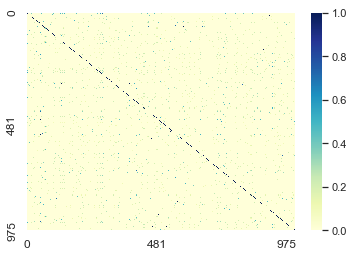

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()
ax = sns.heatmap(first_items.fillna(0), 
                 vmin=0, vmax=1, 
                 cmap='YlGnBu', 
                 xticklabels=250, yticklabels=250)
ax.tick_params(labelsize=12)

## 例9-5. アイテムベース協調フィルタリングによる類似論文のレコメンド

In [6]:
def paper_recommender(paper_ix, items_df):
    print('Based on the paper: \nindex = ', paper_ix)
    print(model_df.iloc[paper_ix])
    top_results = items_df.loc[paper_ix].sort_values(ascending=False).head(4)
    print('\nTop three results: ')
    order = 1
    for i in top_results.index.tolist()[-3:]:
        print(order,'. Paper index = ', i)
        print('Similarity score: ', top_results[i])
        print(model_df.iloc[i], '\n')
        if order < 5: order += 1
            
paper_recommender(2, first_items)

Based on the paper: 
index =  2
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object

Top three results: 
1 . Paper index =  2
Similarity score:  1.0
abstract                                                  NaN
authors     [{'name': 'Jovana P. Lekovich', 'org': 'Weill ...
fos                                                       NaN
keywords                                                  NaN
title       Should endometriosis be an indication for intr...
year                                                     2015
Name: 2, dtype: object 

2 . Paper index =  292
Similarity score:  1.0
abstract                                                  NaN
aut

## 例9-6. 固定幅のビン分割とダミーコーディング

Year spread:  1831  -  2017
Quantile spread:
 0.25    1990.0
0.50    2005.0
0.75    2012.0
Name: year, dtype: float64


Text(0, 0.5, 'Occurrence')

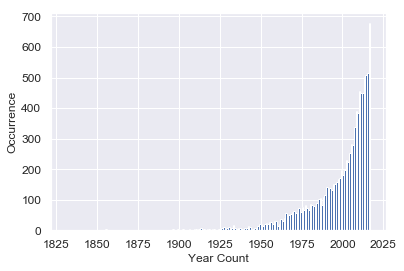

In [7]:
year_min = model_df['year'].min()
year_max = model_df['year'].max()

print('Year spread: ', year_min, ' - ', year_max)
print('Quantile spread:\n', model_df['year'].quantile([0.25, 0.5, 0.75]))

# 分布を確認するために出版年をプロットする
fig, ax = plt.subplots()
model_df['year'].hist(ax=ax, bins= year_max - year_min)
ax.tick_params(labelsize=12)
ax.set_xlabel('Year Count', fontsize=12)
ax.set_ylabel('Occurrence', fontsize=12)


## 例9-7. 固定幅のビン分割とダミーコーディング: part2

In [8]:
# ビンの幅を10年区切りに修正し、特徴空間を156から19に削減
bins = int(round((year_max - year_min) / 10))

temp_df = pd.DataFrame(index = model_df.index)
temp_df['yearBinned'] = pd.cut(model_df['year'].tolist(), bins, precision = 0)

X_yrs = pd.get_dummies(temp_df['yearBinned'])
X_yrs.columns.categories

IntervalIndex([(1831.0, 1841.0], (1841.0, 1851.0], (1851.0, 1860.0], (1860.0, 1870.0], (1870.0, 1880.0] ... (1968.0, 1978.0], (1978.0, 1988.0], (1988.0, 1997.0], (1997.0, 2007.0], (2007.0, 2017.0]],
              closed='right',
              dtype='interval[float64]')

Text(0, 0.5, 'Counts')

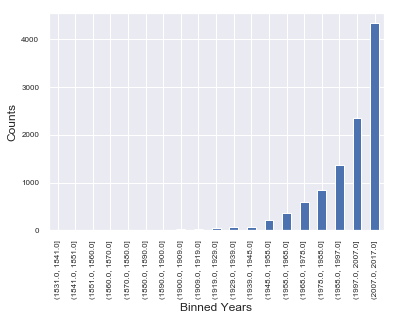

In [9]:
# 新しい分布をプロットする
fig, ax = plt.subplots()
X_yrs.sum().plot.bar(ax = ax)
ax.tick_params(labelsize=8)
ax.set_xlabel('Binned Years', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

## 例9-8. 「bag-of-phrases」データをpd.SeriesからNumPy sparse arrayに変更

In [10]:
X_fos = fos_features.values

print('Our pandas Series, in bytes: ', getsizeof(fos_features))
print('Our pandas Series, in bytes: ', X_fos.nbytes)

Our pandas Series, in bytes:  3772086600
Our hashed numpy array, in bytes:  112


## 例9-9. 協調フィルタリング stage1 + 2: 類似アイテム検索のためのアイテム特徴量行列作成

In [11]:
second_features = np.append(X_fos, X_yrs, axis = 1)

print('The power of feature engineering saves us, in bytes: ',
         getsizeof(first_features) - getsizeof(second_features))

from sklearn.metrics.pairwise import cosine_similarity

def piped_collab_filter(features_matrix, index, top_n):
    item_similarities = \
        cosine_similarity(features_matrix[index:index+1],
                              features_matrix).flatten()
    related_indices = \
        [i for i in item_similarities.argsort()[::-1] if i != index]
    return [(index, item_similarities[index]) for index in related_indices][0:top_n]

The power of feature engineering saves us, in bytes:  14637007


## 例9-10. アイテムベース協調フィルタリングによる類似論文のレコメンド Take2

In [12]:
def paper_recommender(items_df, paper_ix, top_n):
    if paper_ix in model_df.index:
        print('Based on the paper:')
        print('Paper index = ', model_df.loc[paper_ix].name)
        print('Title :', model_df.loc[paper_ix]['title'])
        print('FOS :', model_df.loc[paper_ix]['fos'])
        print('Year :', model_df.loc[paper_ix]['year'])
        print('Abstract :', model_df.loc[paper_ix]['abstract'])
        print('Authors :', model_df.loc[paper_ix]['authors'], '\n')

        array_ix = model_df.index.get_loc(paper_ix)
        top_results = piped_collab_filter(items_df, array_ix, top_n)
        print('\nTop',top_n,'results: ')

        order = 1
        for i in range(len(top_results)):
            print(order,'. Paper index = ', model_df.iloc[top_results[i][0]].name)
            print('Similarity score: ', top_results[i][1])
            print('Title :', model_df.iloc[top_results[i][0]]['title'])
            print('FOS :', model_df.iloc[top_results[i][0]]['fos'])
            print('Year :', model_df.iloc[top_results[i][0]]['year'])
            print('Abstract :', model_df.iloc[top_results[i][0]]['abstract'])
            print('Authors :', model_df.iloc[top_results[i][0]]['authors'], '\n')
            if order < top_n: order += 1
                    
    else:
        print('Whoops! Choose another paper. Try something from here: \n', model_df.index[100:200])

paper_recommender(second_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : nan
Year : 2015
Abstract : nan
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  12673
Similarity score:  1.0
Title : Correlations of Portal Pressure In Benign Biliary Stricture
FOS : nan
Year : 2014
Abstract : nan
Authors : [{'name': 'Hirdaya Nag', 'org': 'G B Pant Hospital and MAM College, New Delhi, India'}, {'name': 'Asit Arora', 'org': 'G B Pant Hospital and MAM College, New Delhi, India'}, {'name': 'Ila Tyagi', 'org': 'G B Pant Hospital and MAM College, New Delhi, India'}, {'na

## 例9-11. loc, iloc, get_locの使い分け(explain_loc_iloc_get_loc.ipynbにより詳しいサンプルコードを追加)

In [13]:
model_df.loc[21]

abstract    A microprocessor includes hardware registers t...
authors                      [{'name': 'Mark John Ebersole'}]
fos         [Embedded system, Parallel computing, Computer...
keywords                                                  NaN
title       Microprocessor that enables ARM ISA program to...
year                                                     2013
Name: 21, dtype: object

In [14]:
model_df.iloc[21]

abstract                                                  NaN
authors     [{'name': 'Nicola M. Heller'}, {'name': 'Steph...
fos         [Biology, Medicine, Post-transcriptional regul...
keywords    [glucocorticoids, post transcriptional regulat...
title       Post-transcriptional regulation of eotaxin by ...
year                                                     2002
Name: 30, dtype: object

In [15]:
model_df.index.get_loc(30)

21

## 例9-12. ストップワード + TF-IDF

In [16]:
filled_df = model_df.fillna('None')

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english')
X_abstract = vectorizer.fit_transform(filled_df['abstract'])

third_features = np.append(second_features, X_abstract.toarray(), axis = 1)

## 例9-13. scikit-learnのDictVectorizerをつかったOne-Hotエンコーディング

In [17]:
authors_list = []

for row in filled_df.itertuples():
    # それぞれのSeriesインデックスからdict型オブジェクトを作成する
    if isinstance(row.authors, str):
        y = {'None': row.Index}
    if isinstance(row.authors, list):
        # これらのキー、値をdict型オブジェクトに追加する
        y = dict.fromkeys(row.authors[0].values(), row.Index)
    authors_list.append(y)

authors_list[0:5]

[{'None': 0},
 {'Ahmed M. Alluwaimi': 1},
 {'Jovana P. Lekovich': 2, 'Weill Cornell Medical College, New York, NY': 2},
 {'George C. Sponsler': 5},
 {'M. T. Richards': 7}]

In [18]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = authors_list
X_authors = v.fit_transform(D)
fourth_features = np.append(third_features, X_authors, axis=1)

## 例9-14. アイテムベース協調フィルタリングによる類似論文のレコメンド Take3

In [19]:
paper_recommender(fourth_features, 2, 3)

Based on the paper:
Paper index =  2
Title : Should endometriosis be an indication for intracytoplasmic sperm injection (ICSI) in fresh IVF cycles
FOS : nan
Year : 2015
Abstract : nan
Authors : [{'name': 'Jovana P. Lekovich', 'org': 'Weill Cornell Medical College, New York, NY'}, {'name': 'G.D. Palermo', 'org': 'Weill Medical College of Cornell University, New York, NY'}, {'name': 'Nigel Pereira', 'org': 'The Ronald O. Perelman and Claudia Cohen Center, New York, NY'}, {'name': 'Zev Rosenwaks', 'org': 'Weill Cornell Medical College, New York, NY'}] 


Top 3 results: 
1 . Paper index =  0
Similarity score:  0.13608276348795434
Title : System and Method for Maskless Direct Write Lithography
FOS : ['Electronic engineering', 'Computer hardware', 'Engineering', 'Engineering drawing']
Year : 2015
Abstract : A system and method for maskless direct write lithography are disclosed. The method includes receiving a plurality of pixels that represent an integrated circuit (IC) layout; identifying 